# Ouvrir la boîte noire avec tf_explain

tf_explain est une bibliothèque open-source proposant plusieurs méthodes de visualisation des pixels importants pour la classification. 

Ces méthodes peuvent s'appliquer de deux manières : 
- Comme des fonctions de rappel : elles sont donc appelées à chaque itération pendant l'entraînement, et appliquées à toutes les images de validation. Les images résultantes sont ensuite sauvegardées dans un dossier ;
- Comme des classes avec des fonctions qui peuvent être appliquées à des images individuelles et à un modèle entraîné. 

C'est ce dernier usage qui sera démontré ici. 

Dans ce notebook, nous allons charger la version 3 du modèle InceptionNet entraîné sur ImageNet, l'appliquer à une image pour prédire sa classe, et utiliser GradCAM et les gradients intégrés pour visualiser les pixels que le modèle a utilisés pour faire sa prédiction.

![ouvrir_la_boite_noire_chien_balle.png](ouvrir_la_boite_noire_chien_balle.png)

## Imports
Nous commençons par importer les paquets nécessaires pour ce notebook. 

La commande ```%matplotlib inline``` permet d'afficher les graphiques de matplotlib avec la bibliothèque graphique intégrée à Notebook. Sans cette commande, les graphiques générés avec ```matplotlib```ne s'afficheront pas. 

Le bibliothèque suivantes sont importées :
- La bibliothèque ```OpenCV```, qui s'importe avec la commande ```import cv2```, nous servira à lire et à prétraiter les images avant qu'elles n'entrent dans le classifieur ;
- ```Matplotlib``` est utilisée pour afficher des images et tracer des courbes ;
- ```Numpy``` sert à faire des calculs matriciels.  Les images lues par ```OpenCV``` sont stockées comme des matrices ```Numpy``` ;
- La bibliothèque ```TensorFlow``` et son module ```Keras``` nous permettront de charger le réseau de neurones pré-entraîné à expliquer ;
- La bibliothèque ```tf_explain``` contient les fonctions d'explication de modèle décrites dans ce fichier. 

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tf_explain

Ce notebook a été créé avec les versions de paquets suivantes :

In [2]:
print("Version d'OpenCV", cv2.__version__)
print("Version de Numpy", np.__version__)
print("Version de Keras", keras.__version__)
print("Version de TensorFlow", tf_explain.__version__)

Version d'OpenCV 4.8.0
Version de Numpy 1.23.4
Version de Keras 2.6.0
Version de TensorFlow 0.3.1


Certains de ces paquets sont installés par défaut à l'installation de Python. D'autres doivent être installés séparément.

Si l'import d'un de ces paquets échoue en renvoyant un message d'erreur spécifiant ModuleNotFoundError, c'est probablement que le paquet n'a pas été installé. Dans ce cas, installez le paquet manquant en exécutant la commande !pip install <paquet manquant>.

La cellule qui suit installe tous les paquets nécessaires à ce notebook. Commentez les lignes correspondant aux paquets qui sont déjà installés, exécutez la cellule pour installer les paquets restants, et exécutez à nouveau la cellule effectuant l'import des modules nécessaires.

In [3]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install tf_explain

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


## Chargement du modèle entraîné
Nous allons utiliser le modèle InceptionNet, préentraîné sur ImageNet. 

Le modèle à proprement parler se trouve dans le module ```InceptionV3``` du paquet ```tensorflow.keras.applications.inception_v3```. C'est donc lui que nous importons en premier. 

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

Nous pouvons maintenant charger le modèle pré-entraîné avec les poids d'ImageNet, et afficher un résumé de sa structure. 

In [5]:
# Charger le modèle InceptionV3 pré-entraîné avec les poids d'ImageNet
inception_model = InceptionV3(weights='imagenet')
print(inception_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Chargement, prétraitement et classification de notre image 

Dans cette partie, nous allons charger notre image et la classifier. 

Pour cela, deux modules du paquet ```tensorflow.keras.applications.inception_v3``` nous seront utiles :
- ```preprocess_input``` est une fonction appliquant tous les prétraitements nécessaires à la classification de l'image par le réseau. Proposer une fonction de prétraitement avec un modèle permet aux utilisateurs de ne pas commettre d'erreurs. Dans le cas d'InceptionNet, ce prétraitement consiste simplement à ramener les intensités entre -1 et 1 ;
- ```decode_predictions``` nous permet de convertir les prédictions renvoyées par le modèle depuis un vecteur à 1 000 éléments (représentant la probabilité que l'image appartienne à chacune des 1 000 classes d'ImageNet) en liste des n classes les plus probables.

Nous importons également le module ```image```du paquet ```tensorflow.keras.preprocessing```, qui permet de charger et redimensionner une image. 

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import decode_predictions, preprocess_input

Les lignes suivantes chargent l'image et la redimensionnent à la taille d'entrée du réseau (299 x 299) et la convertissent en matrice ```Numpy```.

In [7]:
# Chargement et prétraitement de votre image
img_path = "ouvrir_la_boite_noire_chien_balle.png"
img = image.load_img(img_path, target_size=(299, 299))  # Redimensionner l'image à la taille d'entrée d'InceptionV3
x = image.img_to_array(img)

Afin de réaliser une prédiction, le modèle attend un lot d'images, sous la forme d'une matrice de dimensions (n, 299, 299). Nous modifions donc la dimension de notre matrice de taille (299, 299) afin qu'elle ait la taille (1, 299, 299). 

Nous pouvons ensuite appliquer la fonction de prétraitement du modèle à la matrice obtenue. 

La matrice résultante est prête à passer par le réseau pour être classifiée. 

In [8]:
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Faire une prédiction
predictions = inception_model.predict(x)
print("Prédictions", predictions)

Prédictions [[1.32802248e-04 4.75856905e-05 1.05373598e-04 5.49666511e-05
  5.34350256e-05 6.09280723e-05 7.71045161e-05 7.69530452e-05
  1.17612391e-04 7.68946411e-05 1.02771868e-04 1.06569860e-04
  5.99798659e-05 6.45380424e-05 4.85243254e-05 1.52576846e-04
  6.23023079e-05 7.20376411e-05 9.59706595e-05 5.81740205e-05
  7.42139382e-05 4.35071706e-05 2.83569170e-05 5.23608869e-05
  5.26366057e-05 1.41770666e-04 1.09783643e-04 1.29557244e-04
  1.08954446e-04 1.21893048e-04 6.50253060e-05 3.93882365e-05
  8.43357921e-05 3.19033134e-05 5.96713107e-05 7.26207800e-05
  1.40558244e-04 1.61528325e-04 1.10520465e-04 6.53302559e-05
  1.44403704e-04 1.23666963e-04 5.63681715e-05 8.18030385e-05
  2.61986512e-04 4.98368099e-05 6.54397445e-05 5.09842175e-05
  5.85246453e-05 7.56695954e-05 3.18322600e-05 4.87360849e-05
  1.05323263e-04 2.09851132e-04 5.68328178e-05 8.19486668e-05
  9.41640683e-05 2.15953682e-04 7.74251239e-05 1.52485503e-04
  1.14072478e-04 1.44535690e-04 9.85244551e-05 6.98308650e

La prédiction brute est difficilement interprétable. 

Grâce à la fonction ```decode_predictions```, nous allons pouvoir obtenir la probabilité et l'étiquette des classes les plus probables. Cette fonction accepte deux arguments :
- le vecteur de prédictions ;
- le nombre des prédictions les plus probables à décoder. 
En sortie, elle renvoie une liste. Notre modèle ne renvoyant qu'un seul vecteur de prédictions, nous n'utilisons que le premier élément de cette liste. 

In [9]:
# Déduire les 5 classes les plus probables
top_classes = decode_predictions(predictions, top=3)[0]

# Afficher les classes prédites et leurs probabilités
for class_id, class_name, class_prob in top_classes:
    print(class_name, ": ", class_prob)

miniature_poodle :  0.4735906
toy_poodle :  0.42297652
soccer_ball :  0.0073278747


Les trois classes les plus probables sont les suivantes :
- caniche nain (*miniature poodle*, une variété de caniche), avec une probabilité de 47.4 % ;
- caniche toy (*toy poodle*, une autre variété de caniche), avec une probabilité de 42.3 % ;
- un ballon de football (*soccer ball*), avec une probabilité de 0.7 %.

Nous allons maintenant esssayer d'identifier les pixels conduisant le réseau à choisir les classes "caniche nain" et "ballon". Pour cela, nous aurons besoin des indices de ces deux classes. Nous allons utiliser la fonction ```argsort``` pour identifier les indices des prédictions les plus probables. 

In [10]:
print(predictions.argsort()[0, -3:][::-1])

[266 265 805]


La classe "caniche nain" a l'indice 266, tandis que la classe "ballon" a l'indice 805.

In [11]:
caniche_id = 266
ballon_id = 805 

# Grad_CAM

Nous commençons par appliquer Grad_CAM.

La classe correspondante se trouve dans le module ```GradCAM```du paquet ```tf_explain.core.grad_cam```. 

In [12]:
from tf_explain.core.grad_cam import GradCAM

Pour appliquer cette méthode, nous commençons par créer un objet de la classe ```GradCAM```. Le constructeur de cette classe ne nécessite aucun argument. 

Nous créons ensuite un tuple à expliquer. Celui-ci comprend deux éléments :
- une liste d'images : nous lui donnons une liste à un seul élément, notre image ```x``` ;
- une liste d'étiquettes pour ces images. Cette étiquette ne sera pas utilisée par ```GradCAM``` ; nous lui donnons donc la valeur ```None```. 

Nous pouvons maintenant appliquer la fonction ```explain``` de la classe ```GradCAM``` pour générer une carte des pixels importants. Cette fonction prend les arguments suivants en entrée :
- ```validation_data``` est le tuple dont la prédiction doit être expliquée ;
- ```model``` est le modèle à expliquer ;
- ```layer_name``` est le nom de la couche par rapport à laquelle les gradients sont calculés. Par défaut, c'est la denrière couche de convolution qui est utilisée ;
- ```class_index``` est l'indice de la classe dont le gradient est calculé. Par défaut, c'est la classe avec la probabilité la plus grande qui est utilisée ;
- ```image_weight``` est un poids entre 0 et 1 utilisé pour la visualisation de la carte finale, et représente le degré de transparence relatif de l'image originale et de la carte des pixels importants. Un poids de 0 signifie que l'image originale n'est pas du tout visible ; un poids de 1 signifie que seule l'image originale est visible; 
- ```colormap``` désigne la palette de couleur utilisée pour la visualisation. Par défaut, c'est la palette ```cv2.COLORMAP_VIRIDIS```, qui varie du violet (pour les valeurs les plus faibles) au jaune (pour les valeurs les plus élevées) qui est utilisée. 

In [13]:
grad_cam = GradCAM()
data = ([x[0]], None)
caniche_grad_cam = grad_cam.explain(validation_data=data, model=inception_model, layer_name='conv2d_93', class_index=caniche_id, image_weight=0.5, colormap = cv2.COLORMAP_VIRIDIS)
print(caniche_grad_cam.shape)

(299, 299, 3)


La carte obtenue en sortie est une image en couleur de la même taille que l'image originale. Affichons maintenant cette image avec Matplotlib. 

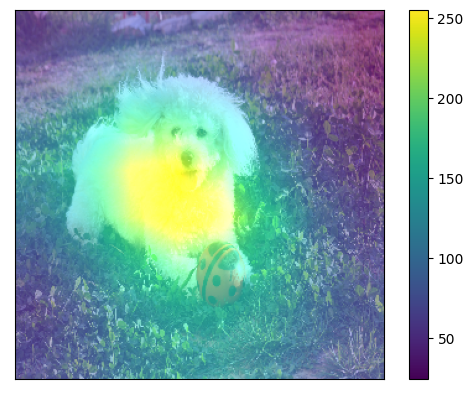

In [14]:
plt.imshow(caniche_grad_cam)
plt.colorbar()  # Afficher l'échelle des différentes couleurs
plt.xticks([])  # Désactiver les étiquettes de l'axe des abscisses
plt.yticks([])  # Désactiver les étiquettes de l'axe des ordonnées
plt.show()

D'après Grad_CAM, ce sont les pixels situés au centre du corps du chien qui incitent le modèle à penser que cette image est celle d'un caniche. 

Visualisons maintenant de la même manière les pixels qui incitent le modèle à penser que cette image est celle d'un ballon de football. 

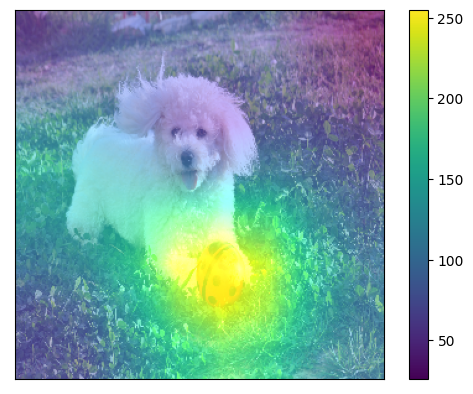

In [15]:
# Calcul de la carte des pixels importants pour la prédiction "ballon de football"
ballon_grad_cam = grad_cam.explain(validation_data=data, model=inception_model, layer_name='conv2d_93', class_index=ballon_id, image_weight=0.5, colormap = cv2.COLORMAP_VIRIDIS)

# Affichage de la carte
plt.imshow(ballon_grad_cam)
plt.colorbar()  # Afficher l'échelle des différentes couleurs
plt.xticks([])  # Désactiver les étiquettes de l'axe des abscisses
plt.yticks([])  # Désactiver les étiquettes de l'axe des ordonnées
plt.show()

D'après Grad_CAM, ce sont les pixels situés autour de la balle du chien qui incitent le modèle à penser que cette image est celle d'un ballon de football. 

# Gradient intégrés

Nous appliquons maintenant l'algorithme des gradients intégrés.

La classe correspondante se trouve dans le module ```IntegratedGradients```du paquet ```tf_explain.core.integrated_gradients```. 

In [16]:
from tf_explain.core.integrated_gradients import IntegratedGradients

Pour appliquer cette méthode, nous commençons par créer un objet de la classe ```IntegratedGradients```. Le constructeur de cette classe ne nécessite aucun argument. 

Nous créons ensuite un tuple à expliquer. Celui-ci comprend deux éléments :
- une liste d'images : nous lui donnons une liste à un seul élément, notre image ```x``` ;
- une liste d'étiquettes pour ces images. Cette étiquette ne sera pas utilisée par ```GradCAM``` ; nous lui donnons donc la valeur ```None```. 

Nous pouvons maintenant appliquer la fonction ```explain``` de la classe ```IntegratedGradients``` pour générer une carte des pixels importants. Cette fonction prend les arguments suivants en entrée :
- ```validation_data``` est le tuple dont la prédiction doit être expliquée. Ce tuple a le même format que celui utilisé par GradCAM ;
- ```model``` est le modèle à expliquer ;
- ```layer_name``` est le nom de la couche par rapport à laquelle les gradients sont calculés. Par défaut, c'est la denrière couche de convolution qui est utilisée ;
- ```class_index``` est l'indice de la classe dont le gradient est calculé. Par défaut, c'est la classe avec la probabilité la plus grande qui est utilisée.

Cette fonction ne propose pas d'options de visualisation (palette de couleur, transparence respective de l'image originale et de la carte de pixels importants) parce qu'elle ne permet pas de superposer les deux images. 

In [17]:
integrated_grad = IntegratedGradients()
caniche_ig = integrated_grad.explain(validation_data=data, model=inception_model, class_index=caniche_id)
print(caniche_ig.shape)

(299, 299)


La carte obtenue en sortie est une image en niveaux de gris de la même taille que l'image originale. Affichons maintenant cette image avec Matplotlib, avec la palette de couleur Viridis. 

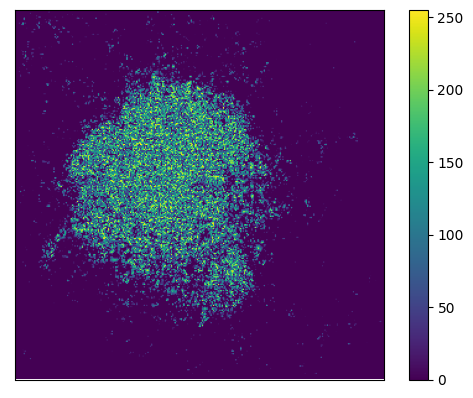

In [18]:
# Affichage de la carte
plt.imshow(caniche_ig)
plt.colorbar()  # Afficher l'échelle des différentes couleurs
plt.xticks([])  # Désactiver les étiquettes de l'axe des abscisses
plt.yticks([])  # Désactiver les étiquettes de l'axe des ordonnées
plt.show()

D'après la méthode des gradients intégrés, ce sont les pixels situés autour du chien qui incitent le modèle à penser que cette image est celle d'un caniche. 

Visualisons maintenant de la même manière les pixels qui incitent le modèle à penser que cette image est celle d'un ballon de football. 

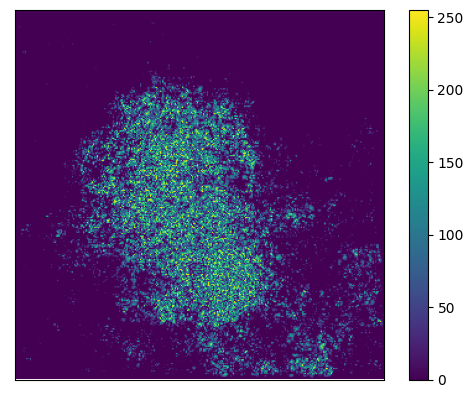

In [19]:
# Calcul de la carte des pixels importants pour la prédiction "ballon de football"
ballon_ig = integrated_grad.explain(validation_data=data, model=inception_model, class_index=ballon_id)

# Affichage de la carte
plt.imshow(ballon_ig)
plt.colorbar()  # Afficher l'échelle des différentes couleurs
plt.xticks([])  # Désactiver les étiquettes de l'axe des abscisses
plt.yticks([])  # Désactiver les étiquettes de l'axe des ordonnées
plt.show()

D'après la méthode des gradients intégrés, les pixels expliquant que cette image soit classifiée comme "ballon de football" s'explique par les pixels situés sur le chien, mais également sur et autour de sa balle. 